---
title: "Exercises"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

Import relevant packages

In [1]:
#| code-fold: false
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import urllib.request
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## intra-annual variability

Go to NOAA's National Centers for Environmental Information (NCEI)  
[Climate Data Online: Dataset Discovery](https://www.ncdc.noaa.gov/cdo-web/datasets)

Find station codes in this [map](https://www.ncei.noaa.gov/maps/monthly/). On the left, click on the little wrench (🔧) next to "Global Summary of the Month", then click on "identify" on the panel that just opened, and click on a station (purple circle). You will see the station's name, it's ID, and the period of record. For example, for Ben-Gurion's Airport in Israel:  
BEN GURION, IS  
STATION ID: ISM00040180  
Period of Record: 1951-01-01 to 2020-03-01

You can download **daily** or **monthly** data for each station. Use the function below to download this data to your computer.

If everything fails and you need easy access to the files we'll be using today, click here:  
<a href="BEN_GURION_monthly.csv" download>Ben Gurion</a>, <a href="BEER_SHEVA_monthly.csv" download>Beer Sheva</a>.

In [2]:
#| code-fold: false
def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data - uncomment the next 2 lines to make this work
    # urllib.request.urlretrieve(url_daily + station_code + '.csv',
    #                            station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

<div class="alert alert-info">
The code above is an example of an API (Application Programming Interface). An API is a set of rules and protocols that allows different software applications to communicate and interact with each other. It acts as an intermediary layer that enables data transmission between different systems or components in a standardized way.
For example, when you use a mobile app to book a ride, the app communicates with the ride-sharing service's systems through their API to request and receive data about available drivers, pricing, and booking details.</div>

Now, choose any station with a period of record longer than 30 years, and download its data:  
```python
download_data('BEN_GURION', 'ISM00040180')
```

Load the data into a datafram, and before you continue with the analysis, plot the rainfall data, to see how it looks like.  

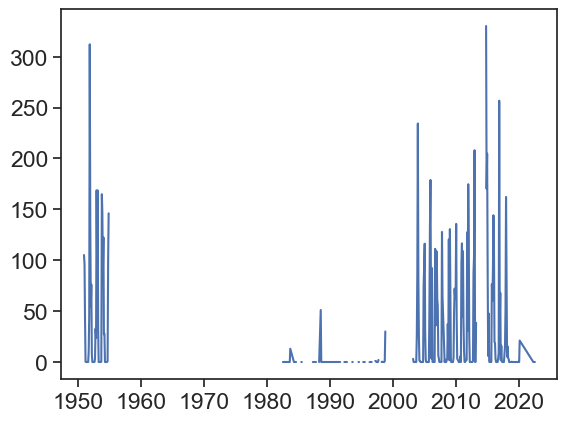

In [3]:
#| code-fold: false
download_data('BEN_GURION', 'ISM00040180')
df = pd.read_csv('BEN_GURION_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP']);

It doesn't look great for Ben-Gurion airport, lots of missing data! You might need to choose another station...  

<div class="alert alert-danger">
ALWAYS look at your data to see if it looks good.  
NEVER mindlessly run code on data you don't know to be good.

$^\star$Of course, if you have a lot of data, you can't look at it with your eyes, and smart methods can be devised to increase the chances that everything is alright.</div>

Download data for Beer Sheva, ID `IS000051690`.

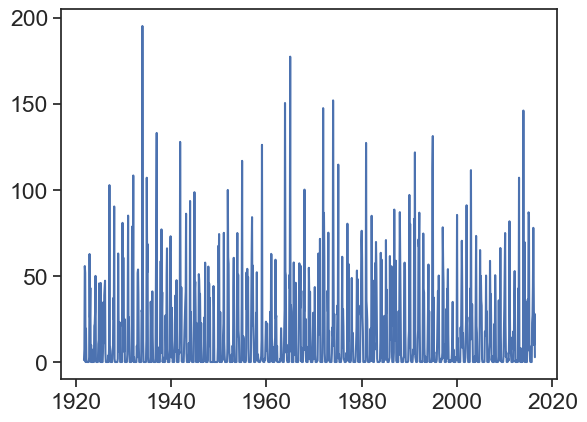

In [4]:
#| code-fold: false
download_data('BEER_SHEVA', 'IS000051690')
df = pd.read_csv('BEER_SHEVA_monthly.csv', sep=",")
# make 'DATE' the dataframe index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
plt.plot(df['PRCP']);

That's much better!
We need to aggregate all data from each month, so we can calculate monthly averages. How to do that?

In [5]:
#| code-fold: false
group_by_month = df['PRCP'].groupby(df.index.month)
df_beersheva = (group_by_month
                  .mean()
                  .to_frame()
               )
df_beersheva = df_beersheva.reset_index()
df_beersheva.columns = ['month number', 'monthly rainfall (mm)']
df_beersheva

,month number,monthly rainfall (mm)
0,1,48.743158
1,2,37.347368
2,3,26.551579
3,4,9.038947
4,5,2.735789
5,6,0.013830
6,7,0.000000
7,8,0.002128
8,9,0.271277
9,10,6.669474


`groupby` is a very powerful tool, but it takes some time to get used to it. We usually make operations on the groupby object like this:
```python
df_beersheva = (df['PRCP']
                  .groupby(df.index.month)
                  .mean()
                  .to_frame()
               )
```

If you try to see the object `group_by_month` you won't see anything. This object waits for further instructions to be useful. Another way of understanding what's going on with this operation is to see with our eyes one of the groups:

```python
group_by_month.get_group(3)

```

If you want to calculate the same averages using a loop instead of `groupby`, then you can do the following:

In [6]:
#| code-fold: false
# choose only the precipitation column
df_month = df['PRCP']
# calculate monthly mean
monthly_mean = np.array([])  # empty array
month_numbers = np.arange(1,13)

for m in month_numbers:      # cycle over months (1, 2, 3, etc)
    this_month_all_indices = (df_month.index.month == m)       # indices in df_month belonging to month m
    this_month_mean = df_month[this_month_all_indices].mean()  # this is the monthly mean
    monthly_mean = np.append(monthly_mean, this_month_mean)    # append

df_beersheva = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                             'month number':month_numbers
                            })
df_beersheva

,monthly rainfall (mm),month number
0,48.743158,1
1,37.347368,2
2,26.551579,3
3,9.038947,4
4,2.735789,5
5,0.013830,6
6,0.000000,7
7,0.002128,8
8,0.271277,9
9,6.669474,10


Plot the data and see if it makes sense. Try to get a figure like this one.

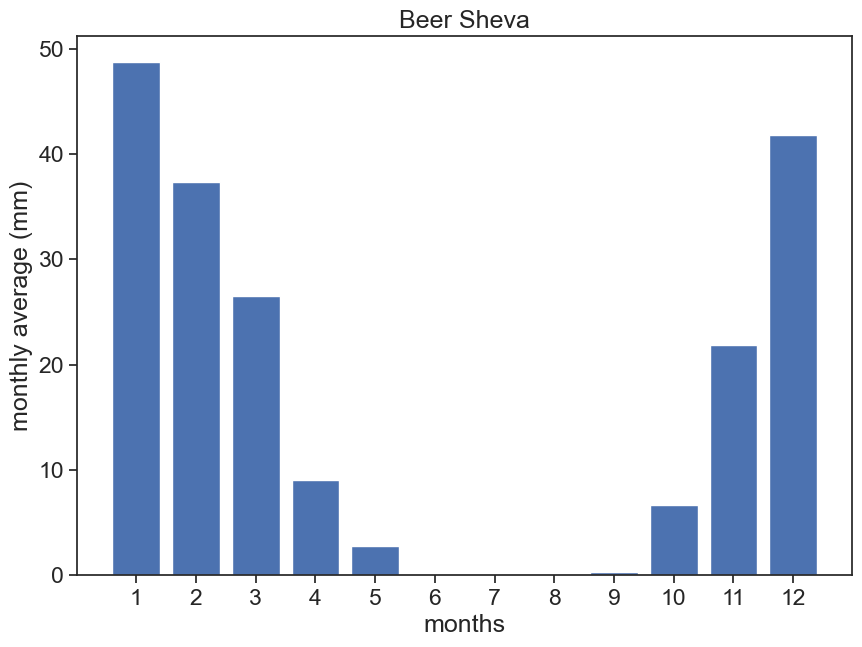

In [7]:
#| code-fold: false
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(df_beersheva['month number'], df_beersheva['monthly rainfall (mm)'])
ax.set(xlabel="months",
       ylabel="monthly average (mm)",
       title="Beer Sheva",
       xticks=df_beersheva['month number'],
       xticklabels=df_beersheva['month number']);
# plt.savefig("beersheva_monthly_average.png")

Let's calculate now the Walsh and Lawler Seasonality Index: @walsh_lawler, @walsh1981rainfall.  
**Write a function** that receives a dataframe like the one we have just created, and returns the seasonality index.  

$R=$ mean annual precipitation  
$m_i=$ precipitation mean for month $i$  

$$ SI = \displaystyle \frac{1}{R} \sum_{n=1}^{n=12} \left| m_i - \frac{R}{12} \right| $$

| SI | Precipitation Regime |
| --- | --- |
| <0.19 | Precipitation spread throughout the year |
| 0.20-0.39	 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59	 | Rather seasonal with a short dry season |
| 0.60-0.79	 | Seasonal |
| 0.80-0.99	 | Marked seasonal with a long dry season |
| 1.00-1.19		 | Most precipitation in < 3 months |

In [8]:
def walsh_index(df):
    mi = df["monthly rainfall (mm)"]
    R = df["monthly rainfall (mm)"].sum()
    SI = np.sum(np.abs(mi - R/12)) / R
    return SI
beersheva_SI = walsh_index(df_beersheva)
print(f"Beer Sheva, SI = {beersheva_SI:.2f}")

Beer Sheva, SI = 0.97
